# Intro
**In version 1 of this notebook i trained the model using vgg19 as a base model via transfer learning, now in the current version, i trained the model using vgg16 as a base model(same architecture just base model is changes from vgg19 to vgg16), then i used Average_Ensembling to get a better accuracy, which is successful since i gt 99% accuracy on test data**

In [ ]:
!pip install tensorflow
!pip install tensorflow-datasets
!pip install tfds-nightly
!pip install matplotlib
!pip install PIL

# **Importing Libraries****

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_datasets as tfdf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **if you are working on google collab you can try importing dataset like this****

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !unzip "/content/drive/MyDrive/Indian Medicinal Leaves Image Datasets.zip"

# **for Distribution of learning - two gpus, T4x2****

In [2]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

# **Importing dataset****
BATCH_SIZE is 32 for 1 gpu,

In [3]:
BATCH_SIZE = 32
batch_size_ = BATCH_SIZE * mirrored_strategy.num_replicas_in_sync
img_height = 224
img_width = 224
CHANNEL = 3
data_dir = r"/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset"
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size_)

Found 6900 files belonging to 80 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']


# **Plotting Images for Visualization****

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Train Test Split****

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [8]:
# resizing images layer, later will be added in the model
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_height),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# **Augmentation****

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.3),
])

In [10]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Importing VGG19 for transfer learning

In [15]:
from tensorflow.keras.applications import VGG16,VGG19, Xception, ResNet50, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet121, NASNetLarge, EfficientNetB0

feature_extractor = VGG16(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")



58889256/58889256 [==============================] - 0s 0us/step


In [16]:
# make sure that layers are not trainable, that is weights of the vgg19 model will not change and we can use it as a feature extractor for our model
for layer in feature_extractor.layers:
    layer.trainable=False

# **Code below is commented,it is for the learning rate, can be used for some experimentation****

In [ ]:
# from tensorflow.keras.optimizers.schedules import ExponentialDecay

# total_epochs = 100
# initial_learning_rate = 5e-3
# decay_rate = 0.9

# lr_schedule = ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=total_epochs // 10,
#     decay_rate=decay_rate,
#     staircase=True
# )




In [ ]:

# epochs = np.arange(1, total_epochs + 1)
# learning_rates = [lr_schedule(epoch) for epoch in epochs]


# plt.plot(epochs, learning_rates, label='Learning Rate')
# plt.title('Exponential Learning Rate Schedule')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.legend()
# plt.show()



# **Defining the model layers**


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

with mirrored_strategy.scope():
    model = keras.Sequential([
        resize_and_rescale,
        layers.BatchNormalization(),
        feature_extractor,
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(80, activation = 'softmax')
        ])



    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    model.build(input_shape = (None, 224, 224,3))

# **plot model architecture****

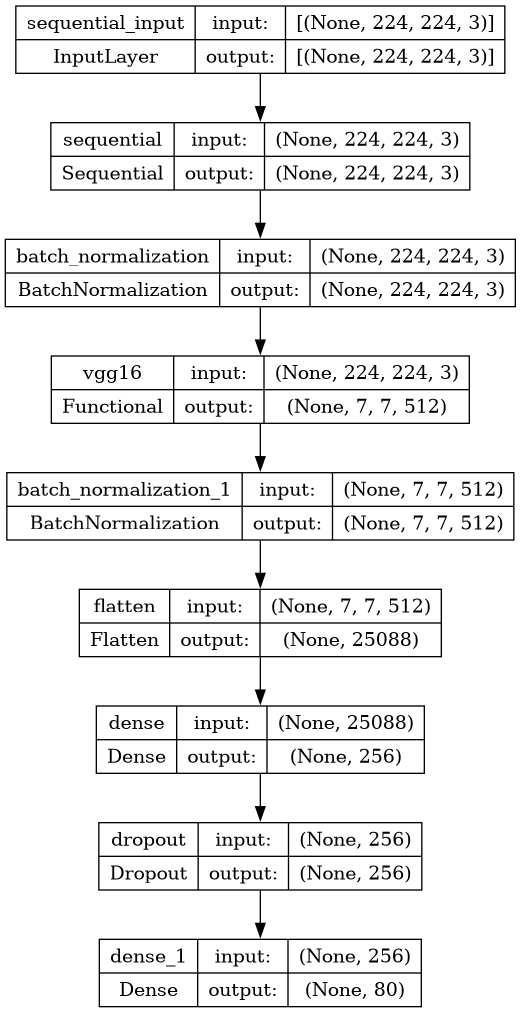

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=800)

# **callback for earlystopping(really helpful for saving time and preventing the model from overfitting)****

In [22]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max' ,
                              patience = 7,
                              verbose = 1)


callback_list = [earlystopping]

In [20]:
model_history=model.fit(train_ds,
                        validation_data=val_ds,
                        epochs = 150,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/150


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


75/75 [==============================] - ETA: 0s - loss: 3.8199 - accuracy: 0.1518

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


75/75 [==============================] - 347s 2s/step - loss: 3.8199 - accuracy: 0.1518 - val_loss: 3.6221 - val_accuracy: 0.2217
Epoch 2/150
75/75 [==============================] - 64s 851ms/step - loss: 2.3551 - accuracy: 0.4175 - val_loss: 2.5687 - val_accuracy: 0.4766
Epoch 3/150
75/75 [==============================] - 64s 856ms/step - loss: 1.6821 - accuracy: 0.5610 - val_loss: 1.5848 - val_accuracy: 0.6592
Epoch 4/150
75/75 [==============================] - 65s 858ms/step - loss: 1.2768 - accuracy: 0.6617 - val_loss: 0.9372 - val_accuracy: 0.8008
Epoch 5/150
75/75 [==============================] - 64s 845ms/step - loss: 1.0226 - accuracy: 0.7304 - val_loss: 0.6381 - val_accuracy: 0.8555
Epoch 6/150
75/75 [==============================] - 64s 850ms/step - loss: 0.8714 - accuracy: 0.7536 - val_loss: 0.5103 - val_accuracy: 0.8750
Epoch 7/150
75/75 [==============================] - 64s 856ms/step - loss: 0.7378 - accuracy: 0.7941 - val_loss: 0.4252 - val_accuracy: 0.8838
Epoch 

In [21]:
# save model
model.save("vgg16_extractor_1.keras")

In [ ]:
# loss and accuracy graph
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(48)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Here i have tried to get better accuracy by compiling the model with smaller learning rate


In [22]:
# from tensorflow.keras.models import Model, load_model
# with mirrored_strategy.scope():
#     model = load_model("/kaggle/working/efficientnet_v2_extractor_2.keras")
#     model.compile(
#             optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#             metrics=['accuracy']
#         )
from tensorflow.keras.models import load_model

with mirrored_strategy.scope():

    model = load_model("/kaggle/working/vgg16_extractor_1.keras")


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 4e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )


In [23]:
model_history_1=model.fit(train_ds,
                        validation_data=val_ds,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
75/75 [==============================] - 67s 846ms/step - loss: 0.1391 - accuracy: 0.9637 - val_loss: 0.1191 - val_accuracy: 0.9707
Epoch 2/100
75/75 [==============================] - 63s 832ms/step - loss: 0.1252 - accuracy: 0.9649 - val_loss: 0.1255 - val_accuracy: 0.9678
Epoch 3/100
75/75 [==============================] - 64s 841ms/step - loss: 0.1075 - accuracy: 0.9731 - val_loss: 0.1298 - val_accuracy: 0.9668
Epoch 4/100
75/75 [==============================] - 64s 844ms/step - loss: 0.1148 - accuracy: 0.9687 - val_loss: 0.1259 - val_accuracy: 0.9658
Epoch 5/100
75/75 [==============================] - 63s 843ms/step - loss: 0.1033 - accuracy: 0.9712 - val_loss: 0.1190 - val_accuracy: 0.9697
Epoch 6/100
75/75 [==============================] - 63s 836ms/step - loss: 0.1010 - accuracy: 0.9737 - val_loss: 0.1170 - val_accuracy: 0.9697
Epoch 7/100
75/75 [==============================] - 64s 853ms/step - loss: 0.0902 - accuracy: 0.9745 - val_loss: 0.1152 - val_accuracy:

# **tried this model but already got better accuracy in the previous one****

In [24]:
model.save("vgg19_extractor_2.keras")

In [30]:
with mirrored_strategy.scope():

# Load the model with the custom_objects parameter
    model = load_model("/kaggle/working/vgg16_extractor_2.keras")

# **evaluating the model on test data****

In [28]:
model.evaluate(test_ds)

17/17 [==============================] - 6s 254ms/step - loss: 0.1908 - accuracy: 0.9586


[0.19078747928142548, 0.9586396813392639]

# Trying Average_Ensemble to get better accuracy****

In [18]:
# model that i just trained above
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

def get_vgg_16_model():
    vgg_16_model = load_model("/kaggle/input/leaves-dataset-models/vgg16_extractor_2.keras")
# Change the names of the layers in VGG16
    for layer in vgg_16_model.layers:
        layer._name = f"{layer.name}_vgg16"
    
    vgg_16_model._name = "vgg16_model" 
    return vgg_16_model

In [16]:
# vgg19 model from previous version of this notebook
def get_vgg_19_model():
    vgg_19_model = load_model("/kaggle/input/leaves-dataset-models/vgg19_extractor_1.5.keras")
    for layer in vgg_19_model.layers:
        layer._name = f"{layer.name}_vgg19"
    
    vgg_19_model._name = "vgg19_model"
    return vgg_19_model

In [26]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Concatenate, Dense, Average

# Assuming get_vgg_19_model and get_vgg_16_model are functions that return the corresponding models
with mirrored_strategy.scope():
# Define input layer
    input_layer = Input(shape=(224, 224, 3), name='input_layer')

# Load pre-trained VGG models
    vgg_19_model = get_vgg_19_model()
    vgg_16_model = get_vgg_16_model()

# Get outputs from the models
    vgg19_output = vgg_19_model(input_layer)
    vgg16_output = vgg_16_model(input_layer)


# Use Average layer to create an ensemble by averaging predictions
    ensemble_output = Average(name='average_ensemble')([vgg19_output, vgg16_output])


# Create the ensemble model
    ensemble_model = Model(inputs=input_layer, outputs=ensemble_output, name='ensemble_model')

# Compile the model
    ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])





In [27]:
ensemble_model.evaluate(test_ds)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 445 extraneous bytes before marker 0xd9


17/17 [==============================] - 114s 547ms/step - loss: 0.0696 - accuracy: 0.9908


[0.06960482150316238, 0.9908088445663452]

In [30]:
ensemble_model.save("ensemble_vgg19_vgg16.keras")

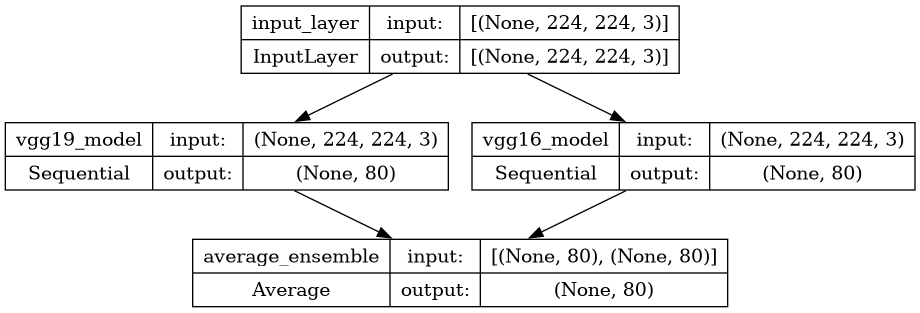

In [40]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(ensemble_model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=800)

# **Evaluation metrics - classification Report, precision, recall, f1 score etc., to evaluate the model performance**** 

In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import tensorflow as tf

# Function to predict a single image
def predict(model, image):
    predictions = model.predict(np.expand_dims(image, axis=0), verbose=0)

    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions) * 100

    return predicted_class, confidence

In [32]:
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    for i in range(len(labels)):
        true_labels.append(labels[i].numpy())

        predicted_class, _ = predict(ensemble_model, images[i].numpy())
        predicted_labels.append(predicted_class)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


In [33]:
# cm = confusion_matrix(true_labels, predicted_labels)
# plt.figure(figsize=(8, 8))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

In [33]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.9914
Recall: 0.9908
F1 Score: 0.9908


first image to predict
actual label: Kasambruga
2/2 [==============================] - 3s 292ms/step
predicted label: Kasambruga


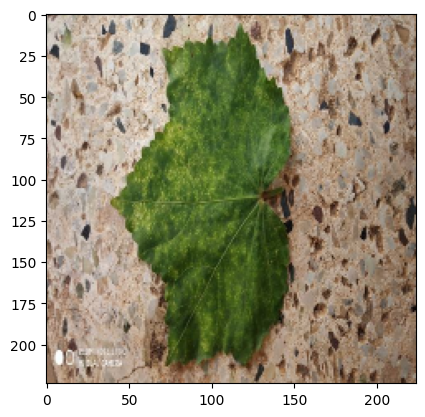

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = ensemble_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose = 0)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

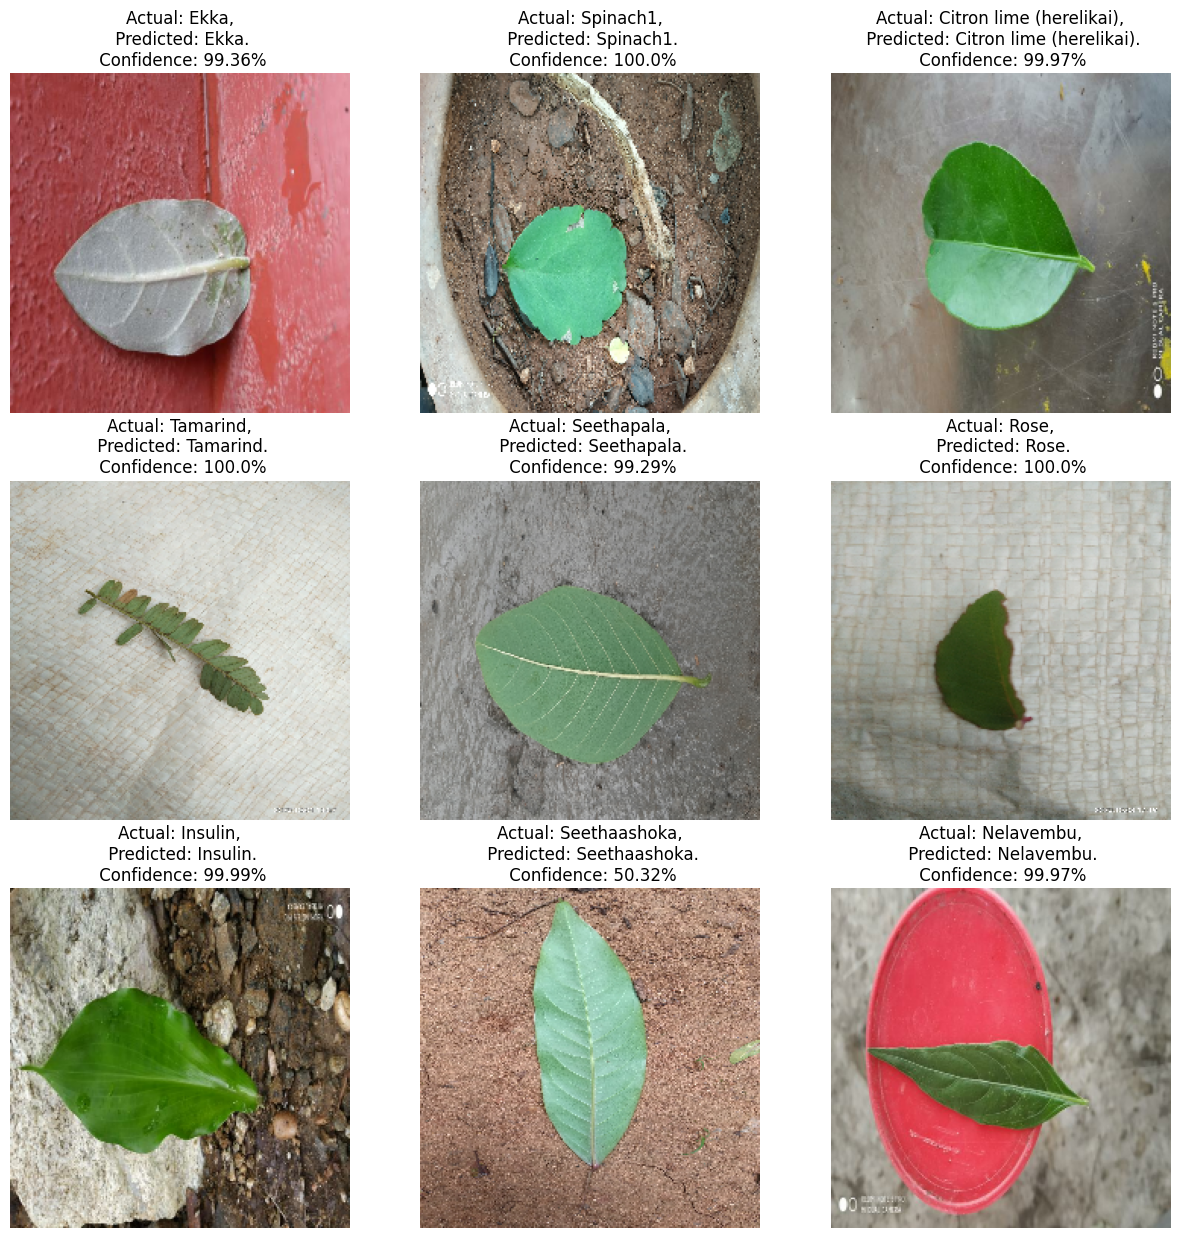

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(ensemble_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [37]:
from sklearn.metrics import classification_report
from prettytable import PrettyTable

report = classification_report(true_labels, predicted_labels)
# print("Classification Report:\n", report)
table = PrettyTable()
table.field_names = ["Classification Report", "Class Names"]

table.add_row([report, '\n'.join(f"{i}: {class_name}" for i, class_name in enumerate(class_names))])

table.align["Classification Report"] = "l"
table.align["Class Names"] = "l"

print(table)






+-------------------------------------------------------+-----------------------------+
| Classification Report                                 | Class Names                 |
+-------------------------------------------------------+-----------------------------+
|               precision    recall  f1-score   support | 0: Aloevera                 |
|                                                       | 1: Amla                     |
|            0       1.00      1.00      1.00        10 | 2: Amruthaballi             |
|            1       1.00      1.00      1.00        13 | 3: Arali                    |
|            2       1.00      0.94      0.97        18 | 4: Astma_weed               |
|            3       1.00      1.00      1.00        17 | 5: Badipala                 |
|            4       1.00      1.00      1.00        15 | 6: Balloon_Vine             |
|            5       1.00      1.00      1.00         9 | 7: Bamboo                   |
|            6       1.00      1

# **Top missclassification**** 

In [38]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Set diagonal elements (correct predictions) to 0
np.fill_diagonal(conf_matrix, 0)

# Find the indices of top N misclassifications
N = 5
top_misclassifications = np.argsort(-conf_matrix.flatten())[:N]

# Convert flat indices to row and column indices
top_misclass_rows, top_misclass_cols = np.unravel_index(top_misclassifications, conf_matrix.shape)

# Print the top N misclassifications
for i in range(N):
    true_class = class_names[top_misclass_rows[i]]
    predicted_class = class_names[top_misclass_cols[i]]
    count = conf_matrix[top_misclass_rows[i], top_misclass_cols[i]]
    print(f"True class: {true_class}, Predicted class: {predicted_class}, Count: {count}")


True class: Jackfruit, Predicted class: Seethapala, Count: 1
True class: Coriender, Predicted class: Tomato, Count: 1
True class: Amruthaballi, Predicted class: Ekka, Count: 1
True class: Gasagase, Predicted class: Lantana, Count: 1
True class: Pomoegranate, Predicted class: Chilly, Count: 1


# **Testing on my own images****

In [ ]:
import cv2
img_path = r""
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

In [ ]:
resized_img = tf.image.resize(img, (224,224))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [ ]:
yhat=model.predict(np.expand_dims(resized_img/255, 0))
print(yhat)

In [ ]:
print(np.argmax(yhat))
predicted_label = class_names[np.argmax(yhat)]
print(predicted_label)